In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This is a new, but powerful library for time series analysis and handling real-world dates
import pandas as pd
import numbers
from scipy.stats import qmc 

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

date_beg = '2000-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

dt = 1 # Time step [day]

N_runs = 500 # Number of simulations to perform
DD_lower = 1.0  # Lower bound for degree-day factor
DD_upper = 10.5 # Upper bound for degree-day factor
Tt_lower = -1.0 # Lower bound for temperature threshold
Tt_upper = 7.0  # Upper bound for temperature threshold

## 2. Define the Model - Snow 17

New for this time, we will define our model as a function. A function is just a block of code that is a repeated set of calculations we might want to perform over and over again. This allows us to define the function once and call it many, many times. Here is a link where you can learn more about how to create functions. 

In our case, our function is called `Snow17`. It takes as input the time series of mean daily air temperature (`Ta` in °C) and daily total precipitation (`P` in mm) that are forcings of the model. It also takes as input the value of the degree-day melt factor ($D_D$) and threshold temperature ($T_t$) that will be used as parameter values for a single simulation. The `Snow17` function returns an array of simulated values of SWE, snow melt flux, and liquid precipitation for each time step of the input air temperature and precipitation. In the code that follows, we will call our function, `Snow17`, with many different combinations of parameters. 

Finally, pay attention to the three lines of code that call `assert`. Can you tell what this is doing? Why might it be helpful?  

In [2]:
def Snow17(Ta,P,DD,Tt):
    
    assert Ta.shape == P.shape, 'Precipitation and Temperature vectors must have the same shape'
    assert isinstance(DD, numbers.Number), 'Degree day coefficient must be a scalar'
    assert isinstance(Tt, numbers.Number), 'Temperature threshold must be a scalar'

    Nt = np.max(Ta.shape)
    
    SWE_s17 = np.zeros(Ta.shape)
    Sm_s17 = np.zeros(Ta.shape)
    Pliq_s17 = np.zeros(Ta.shape)
    
    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed, 
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0 
        else:
            SWE_i = SWE_s17[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.
            
        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0
        
        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0
        
        SWE_s17[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_s17[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        Pliq_s17[i] = Pliq_i
        
        
    return SWE_s17, Sm_s17, Pliq_s17

## 3. Create the Parameter Combinations 

We want to create a reasonably large number of possible parameter combinations that span the range of the feasible parameter space, without having to consider every parameter combination (we could do that, but it would be computationally expensive).

*One* way to do this is to use something called Latin Hypercube (LHC) sampling. A latin hypercube gives us random samples between the lower and upper limit of our parameter space, but tries to make sure we have good "coverage" of the parameter sample space. That is, it tries to ensure that our parameters aren't too clustered in one part of the sample space. Below, we use an LHC sampler and plot all of the parameter combinations that we will be considering in our model runs

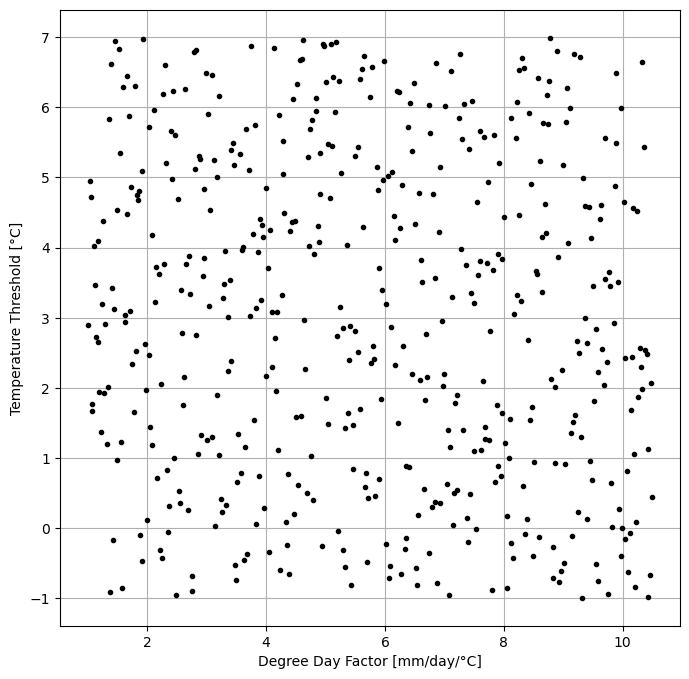

In [3]:
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(N_runs)

l_bounds = [DD_lower, Tt_lower]
u_bounds = [DD_upper, Tt_upper]

sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

plt.figure(figsize=(8,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

## 4. Load the Forcing and Observed SWE Data

Below, we use Pandas to load the forcing and observed SWE data. We also create a plot just to make sure that the precipitation and temperature data doesn't contain any obvious outliers. 

In [4]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


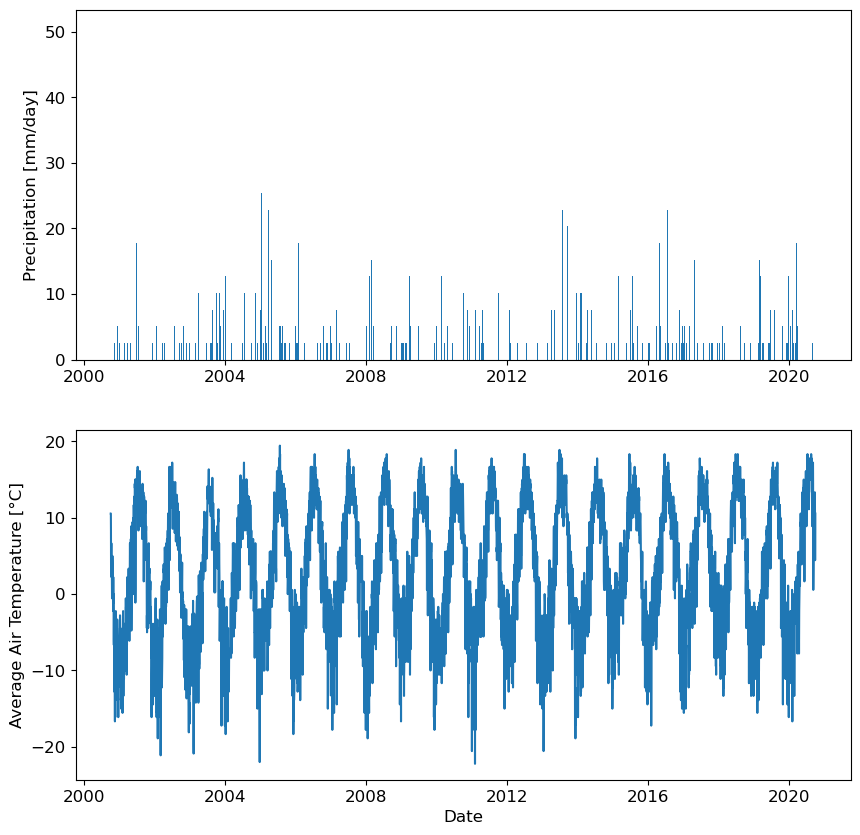

In [5]:
# Plot temperature and precipitation during the period
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.bar(df_forcing['Date'][date_beg:date_end].values,df_forcing['pcp'][date_beg:date_end].values)
plt.ylabel('Precipitation [mm/day]')
plt.subplot(2,1,2)
plt.plot(df_forcing['Date'][date_beg:date_end].values,df_forcing['tair'][date_beg:date_end].values)
plt.xlabel('Date')
plt.ylabel('Average Air Temperature [°C]')
plt.show()

### 4.1 Get Forcing Data and Create Storage Variables

We will store the forcing data for the model simulation period in some `numpy` arrays, create a time series of dates during the simulation period, and set up storage containers for our simulations.

In [6]:
ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P_exp = df_forcing[date_beg:date_end]['pcp'].values
Ta_exp = df_forcing[date_beg:date_end]['tair'].values

In [7]:
t = pd.date_range(start=date_beg, end=date_end, freq='1D')
Nt = t.size

SWE_exp = np.zeros((Nt,N_runs))
Sm_exp = np.zeros((Nt,N_runs))
Pliq_exp = np.zeros((Nt,N_runs))

## 5. Run the Model and Plot Results

Below is our main modeling loop. See how much more succinct the code is now that we have put our Snow-17 code in its own function. 

In [8]:
for r in np.arange(N_runs):

    # Create temporary storage containers for this replicate/run
    SWE_rep = np.zeros((Nt))
    Sm_rep = np.zeros((Nt))
    Pliq_rep = np.zeros((Nt))
    
    # Get the degree-day factor and temperature threshold parameters for this run 
    DD_r = sample_scaled[r,0]
    Tt_r = sample_scaled[r,1]
    
    # Call the Snow-17 model with input forcings and parameters
    SWE_rep, Sm_rep, Pliq_rep = Snow17(Ta_exp,P_exp,DD_r,Tt_r)
    
    # Store the returned vectors in our containers for the whole experiment
    SWE_exp[:,r] = SWE_rep
    Sm_exp[:,r] = Sm_rep
    Pliq_exp[:,r] = Pliq_rep # note: we're note going to do anything with this now

### 5.1 Plot All Model Simulations

Below we will plot the entirety of our simulations of SWE and snowmelt flux. We will plot each run individually as well as the mean across all of the simulations – the so-called ensemble mean. Because we have observed SWE at the Snotel station, we will also plot that to compare to our SWE simulations. 

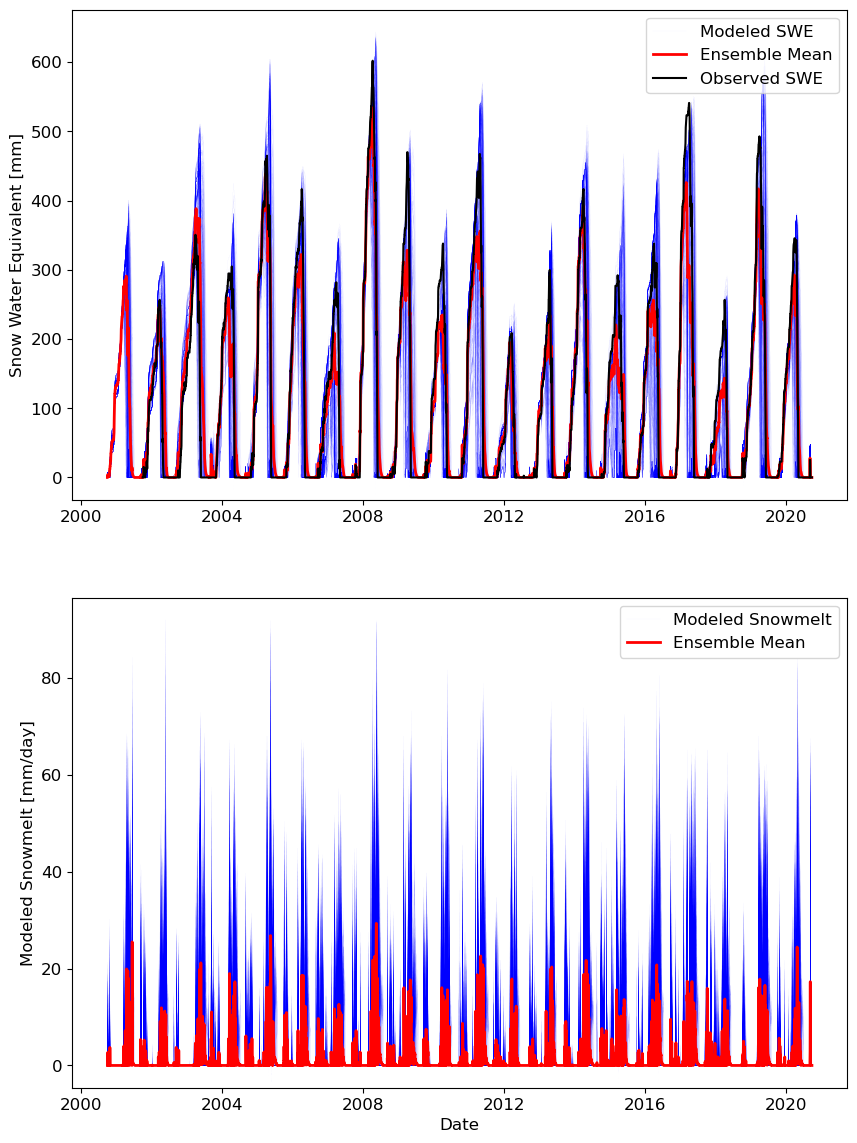

In [9]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,14))

for r in np.arange(N_runs):
    plt.subplot(2,1,1)
    if r == 0:
        plt.plot(t,SWE_exp[:,r],'b-',label='Modeled SWE', linewidth=0.01)
    else:
        plt.plot(t,SWE_exp[:,r],'b-', linewidth=0.01)
    
    plt.subplot(2,1,2)
    if r == 0:
        plt.plot(t,Sm_exp[:,r],'b-',label='Modeled Snowmelt', linewidth=0.01)
    else:
        plt.plot(t,Sm_exp[:,r],'b-', linewidth=0.01)

plt.subplot(2,1,1)
plt.plot(t,np.mean(SWE_exp,1),'r-',label='Ensemble Mean', linewidth=2.0)
plt.plot(t,df_forcing[date_beg:date_end]['SWE'].values,'k-',label='Observed SWE')
plt.ylabel('Snow Water Equivalent [mm]')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.plot(t,np.mean(Sm_exp,1),'r-',label='Ensemble Mean', linewidth=2.0)
plt.xlabel('Date')
plt.ylabel('Modeled Snowmelt [mm/day]')
plt.legend(loc='upper right')
plt.show()


## 6. Compute and Visualize Error Metrics

Now we will compute a variety of individual and compound error metrics to assess the performance of our Snow-17 simulations. We will compute each metric for all combinations of parameters that we considered. We will then map how the value of each error metric varies with the value of the parameters. This will be done via contour maps of the value of the error metric in the parameter space. What we're looking to assess is whether there is a seemingly small area of parameter values that are associated with ideal values of our error metrics, or whether it's more complicated than that? The error metrics we are discussing are commonly used as __objective functions__ that we seek to minimize (like Root Mean Squared Error, RMSE) or maximize (like the Kling Gupta Efficiency, KGE). 

Specifically, as you review the plots below, think about the following questions for each error metric as an objective function:

* How would you describe the shape of the objective function? Is it like a 2-D parabola? A saddle function? A hyperbola? Etc. 
* What does the shape of the objective function in our parameter space imply about whether an "optimal" or close to optimal set of parameters exists? Does only a small range of parameters minimize/maximize the objective function? Or is there a wide space? 
* If there is a really wide space of parameters that minimize/maximize the objective function, what does this imply about the model? Is this good or problematic? If it's problematic, how would we address the problematic nature.  

### 6.1 Bias

Recall that the bias is defined as:

$$
BIAS = \mu_m - \mu_o
$$

where $\mu_m$ is the mean of the model predictions and $\mu_o$ is the mean of the observations over the same period of time. Values of $BIAS > 0$ indicates parameter combinations that __overestimate__ SWE relative to observations, whereas values of $BIAS < 0$ indicate __underestimates__ of SWE. These are often (and sometimes unhelpfully) translated into the parlance of the model being simulated. So, $BIAS > 0$ might be called a __*wet bias*__ while $BIAS < 0$ might be called a __*dry bias*__. A final note, $BIAS$ has units that are the same as the variable we're assessing performance of (SWE in this case). That can give us an intuitive idea of how severe of an under- or over-estimate the model produces. For example a bias of -1 mm is intuitively small, but a bias of -250 mm is large. 

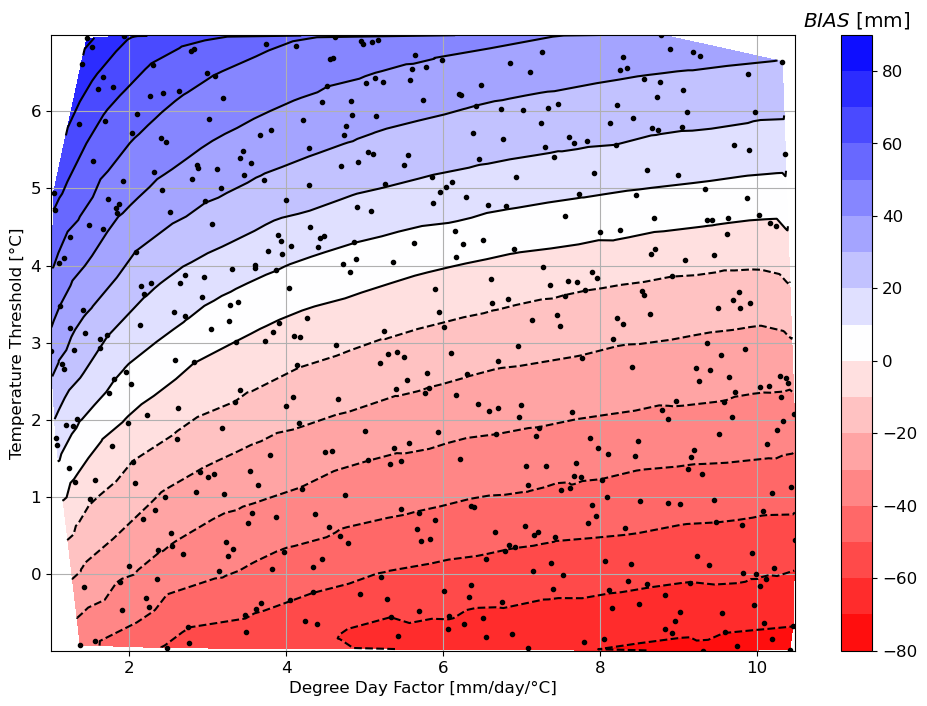

In [10]:
BIAS = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    BIAS[r] = np.nanmean(SWE_exp[:,r]) - np.nanmean(SWE_o)
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(BIAS),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(BIAS),levels=15,cmap='bwr_r')
cb = plt.colorbar()
cb.ax.set_title('$BIAS$ [mm]')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()


### 6.2 Root Mean Squared Error (RMSE)

Recall that the root mean squared error (RMSE) is defined as:

$$
RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_{m,i} - y_{o,i})^2}
$$

where $N$ is the number of simulation points (number of days in our simulation in this case), $y_{m,i}$ is the model-predicted SWE on day $i$ and $y_{o,i}$ is the observed SWE on day $i$. The ideal value of RMSE is 0, which would indicate a perfect simulation. Note that like the bias above, the RMSE has convenient units that are the same as the variable we're trying to predict – SWE. 

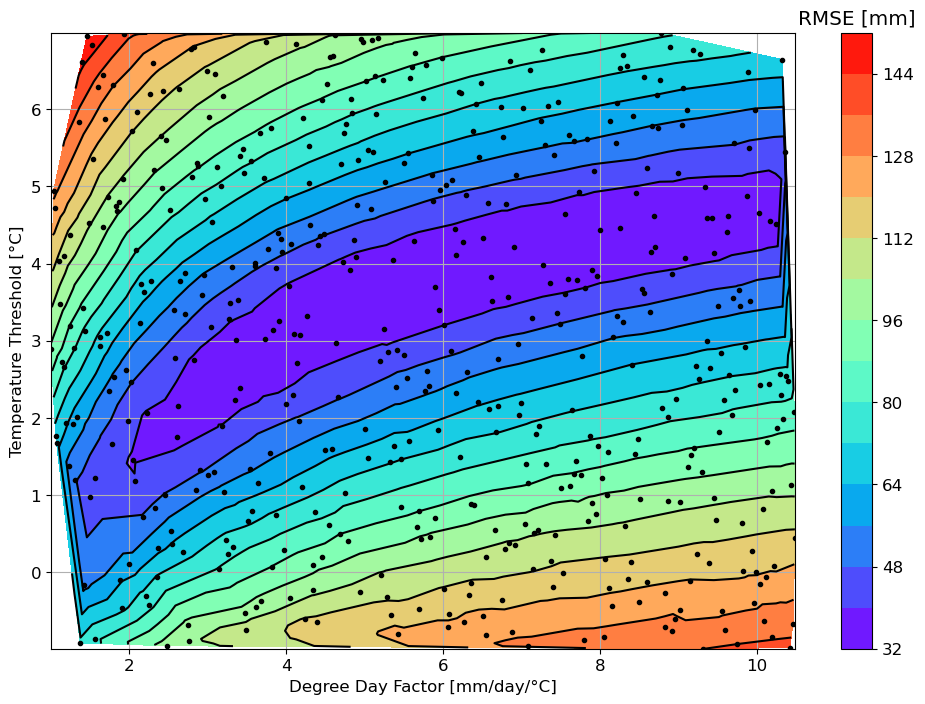

In [11]:
RMSE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    RMSE[r] = np.sqrt(np.nanmean((SWE_exp[:,r] - SWE_o)**2))
    
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(RMSE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(RMSE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('RMSE [mm]')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### 6.2 Mean Absolute Error, MAE

Recall that the definition of mean absolute error (MAE) is:

$$
MAE = \frac{1}{N}\sum_{i=1}^{N}\left| y_{i,m} - y_{o,i} \right|
$$

Like RMSE, MAE is always positive, but does not punish extreme over- or under-predictions, unlike RMSE. Like bias and RMSE, also is associated with units that are the same as the variable we're assessing model performance of. 


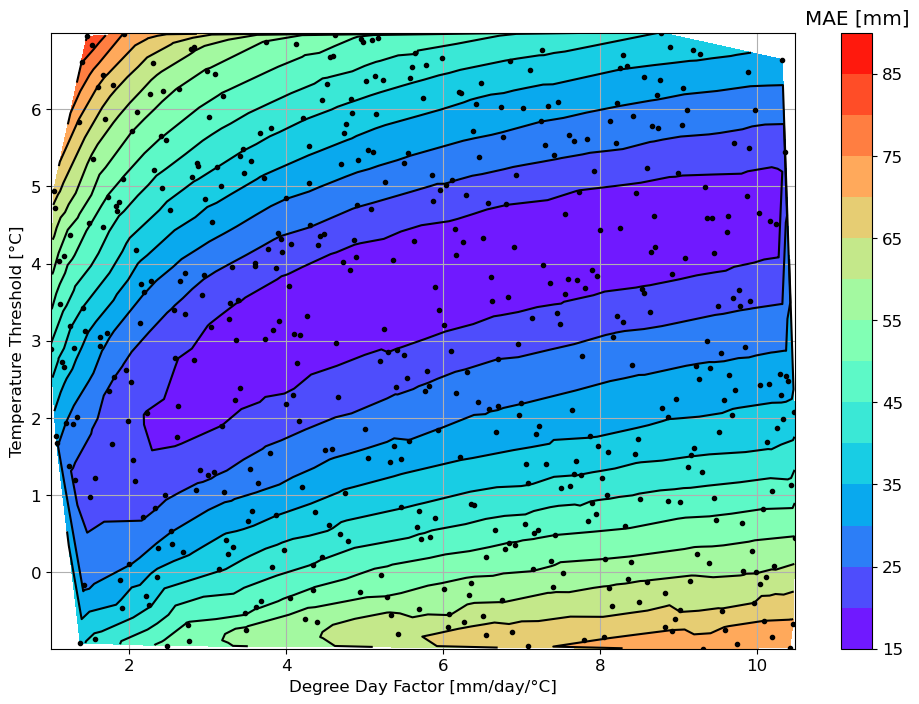

In [12]:
MAE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    MAE[r] = np.nanmean(np.abs(SWE_exp[:,r] - SWE_o))
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(MAE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(MAE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('MAE [mm]')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### 6.3 Pearson Correlation Coefficient

The Pearson correlation coefficient is a measure of linear relationship between the model predictions of SWE on each day ($y_{m,i}$) and the corresponding observations of SWE on each day ($y_{o,i}$). It varies from -1 to 1. A value of 1 means that the model perfectly predicts the observations. The Pearson correlation coefficient can be calculated as:

$$
\rho_{m,o} = \frac{1}{N-1}\frac{1}{\sigma_m \sigma_o}\sum_{i=1}^{N}(y_{m,i} - \mu_m)(y_{o,i} - \mu_o)
$$

where $\sigma_m$ is the standard deviation of the simulated values of SWE and $\sigma_o$ is the standard deviation of observed values of SWE over the same period. Similarly, $\mu_m$ is the average of the simulated values of SWE and $\mu_o$ is the average of observed values of SWE over the same period.

Note, in the below code, we are using the Pandas `df.corr()` function to compute the correlation coefficient. We do this because there are `nan` values in the observed SWE – before the Snotel station was installed.

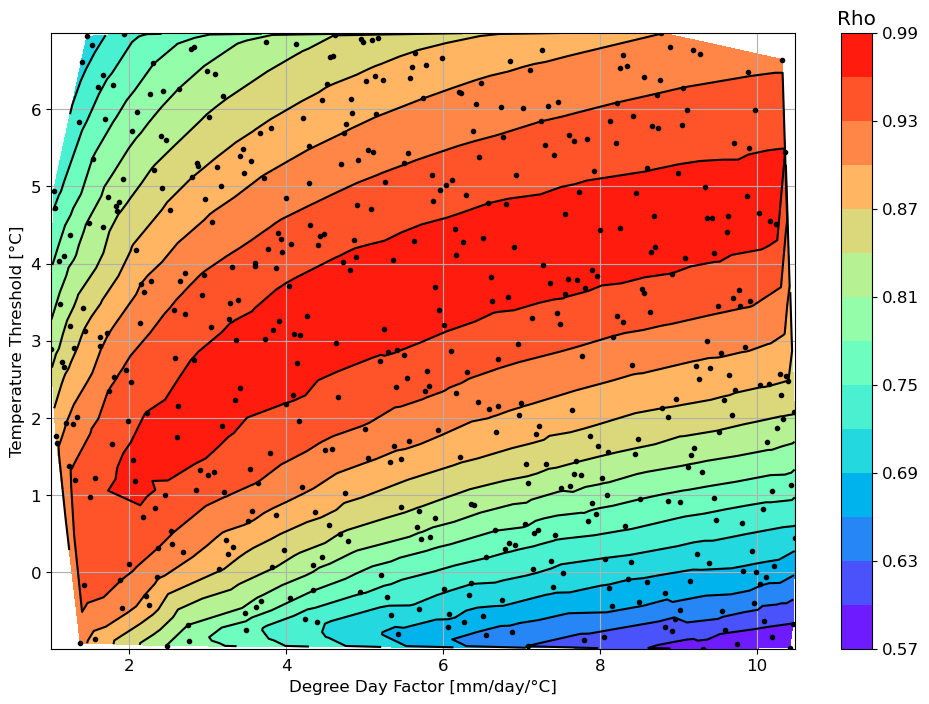

In [13]:
Rho = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    df_swe = pd.DataFrame({'SWE_m': SWE_exp[:,r], 'SWE_o': SWE_o})
    Rho_mat = df_swe.corr().values
    Rho[r] = Rho_mat[1,0]
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(Rho),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(Rho),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('Rho')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### 6.4 Kling Gupta Efficiency (KGE)

The Kling Gupta Efficiency (KGE) score is a compound error metric that is often used as an objective function in the hydrologic sciences. It incorporates several measures of model performance, including a comparison of the modeled versus observed mean and standard deviation, and the Pearson correlation coefficient. 

$$
KGE = 1 - \sqrt{(\rho - 1)^2 + (\alpha - 1)^2 + (\beta - 1)^2}
$$

where $\rho$ is the correlation coefficient between the simulated and observed SWE, and

$$
\beta = \frac{\mu_m}{\mu_o},
$$

with $\mu_m$ being the mean of the modeled values and $\mu_o$ being the mean of the observations over the simulated time period, and

$$
\alpha = \frac{\sigma_m}{\sigma_o},
$$

with $\sigma_m$ being the mean of the modeled values and $\sigma_o$ being the standard deviation of the observations over the simulated time period.

Note that the ratio of the modeled to observed means is effectively a measure of bias, as an unbiased model would produce a value of $\beta$ of 1. Similarly $\alpha$ represents the degree to which the model produces too much $\beta > 1$ or too little $\beta < 1$ variability with respect to the observations. 

A perfect value of KGE would be a value of 1, given that this would require $\rho = 1$, $\alpha = 1$, and $\beta = 1$. 


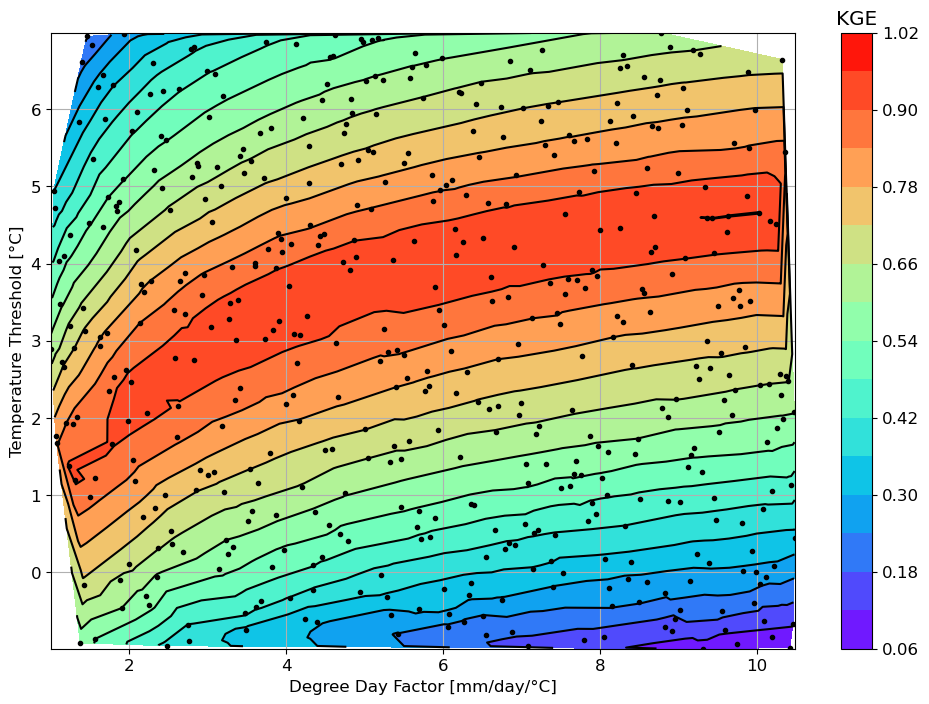

In [14]:
KGE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    # Correlation coefficient
    df_swe = pd.DataFrame({'SWE_m': SWE_exp[:,r], 'SWE_o': SWE_o})
    Rho_mat = df_swe.corr().values
    Rho = Rho_mat[1,0]
    
    # Normalized mean
    beta = np.nanmean(SWE_exp[:,r]) / np.nanmean(SWE_o)
    
    # Normalized standard deviation
    alpha = np.nanstd(SWE_exp[:,r]) / np.nanstd(SWE_o)
    
    # Compute Kling-Gupta Efficiency
    KGE[r] = 1 - np.sqrt((Rho - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(KGE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(KGE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('KGE')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    

### 6.5 Nash-Sutcliffe Efficiency (NSE)

The Nash-Sutcliffe Efficiency (NSE) score is another compound measure that is used as a model performance measure and objective function in hydrology. It is defined as,

$$
NSE = 1 - \frac{\sum_{i=1}^{N}(y_{o,i} - y_{m,i})^2}{\sum_{i=1}^{N}(y_{o,i} - \mu_o)^2}
$$

where all terms are the same as defined above. Effectively, the NSE assesses the degree to which the model serves as a better predictor of the observations than simply taking the long-term mean of the observations. If we think of that long-term mean of the observations as a measure of "climate", NSE asks "can the model beat an estimate based purely on climate?" 

A perfect value of NSE is 1, which can only happen if the model predictions perfectly reproduce the observations. An NSE value of 0 indicates that the long-term observed mean is a better estimate than the mode and NSE can be negative, which would indicate that the model is __worse__ than the long-term mean as a prediction. 

A downside of NSE is that there's no objective sense of what constitutes a "good" model. In some quarters of the literature, authors report NSE > 0.85 is a skillful model, while others say that a skillful model can be associated with NSE > 0.60. 

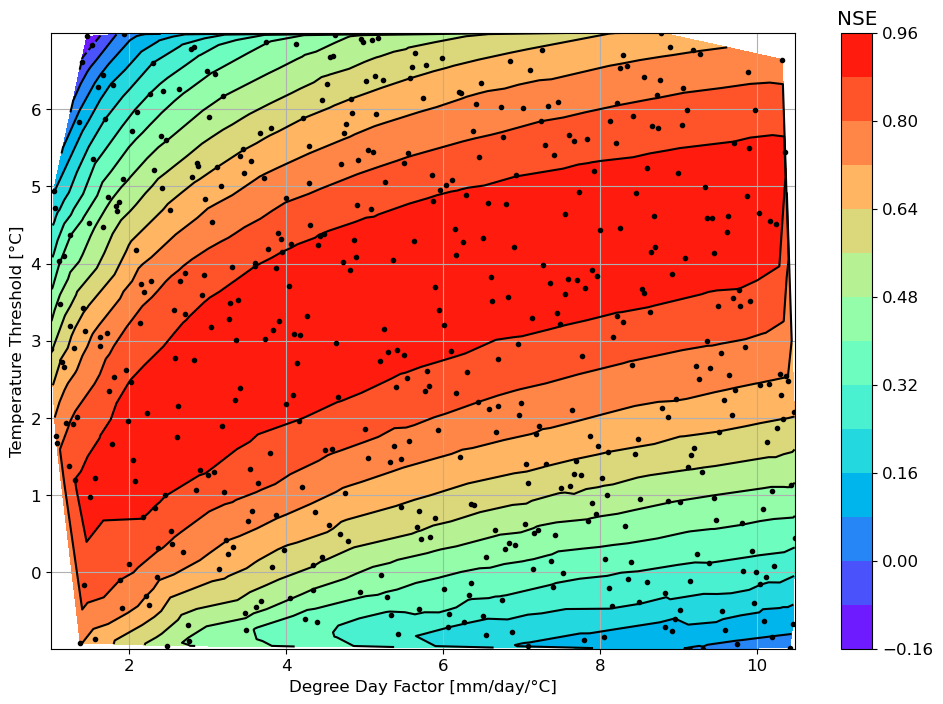

In [15]:
NSE = np.full((N_runs,1),np.nan)

SWE_o = df_forcing[date_beg:date_end]['SWE'].values

for r in np.arange(N_runs):
    NSE[r] = 1 - (np.nansum((SWE_o - SWE_exp[:,r])**2) / np.nansum((SWE_o - np.nanmean(SWE_o))**2))
    
plt.figure(figsize=(12,8))
plt.plot(sample_scaled[:,0],sample_scaled[:,1],'k.')
plt.tricontour(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(NSE),levels=15,colors='k')
plt.tricontourf(sample_scaled[:,0],sample_scaled[:,1],np.squeeze(NSE),levels=15,cmap='rainbow')
cb = plt.colorbar()
cb.ax.set_title('NSE')
plt.xlabel('Degree Day Factor [mm/day/°C]')
plt.ylabel('Temperature Threshold [°C]')
plt.grid('on')
plt.show()

    